In [1]:
import os
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
import biorsp as rsp

/Users/cytronicoder/miniforge3/envs/biorsp-ismb/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
ch.setFormatter(formatter)
logger.addHandler(ch)

In [3]:
cond_map = {
    "Normal": "normal",
    "AKI": "acute kidney failure",
    "CKD": "chronic kidney disease",
    "Pooled": None,
}
region_map = {
    # "C-TAL": ["C-TAL"],
    # "M-TAL": ["M-TAL"],
    # "aTAL": ["aTAL1", "aTAL2"],
    "Pooled": None,
}

In [4]:
def match_gene_name(adata, gene):
    if "feature_name" in adata.var.columns:
        matches = adata.var[adata.var["feature_name"].str.contains(gene, case=False)]
        if not matches.empty:
            return matches.index[0]
    raise ValueError(f"Gene '{gene}' not found in dataset.")


def get_expression_array(adata, gene):
    idx = gene if gene in adata.var_names else match_gene_name(adata, gene)
    col = adata[:, idx].X
    expr = col.toarray().ravel() if sparse.issparse(col) else col.ravel()
    return expr


def get_quantile_bin_mask(adata, gene, q_low, q_high):
    expr = get_expression_array(adata, gene)
    nz = expr[expr > 0]
    if nz.size == 0:
        return np.zeros_like(expr, dtype=bool)
    low_th = np.quantile(nz, q_low)
    high_th = np.quantile(nz, q_high)
    return (expr >= low_th) & (expr <= high_th)

In [5]:
def make_plot_title(gene_A, gene_B, q_low, q_high, cond_label, region_label):
    cond = cond_label if cond_label != "Pooled" else "All conditions"
    region = (
        f"{region_label}"
        if region_label != "Pooled"
        else "Whole TAL region"
    )
    return (
        f"{gene_A}/{gene_B} co-expression ({int(q_low*100)} - {int(q_high*100)}%)\n"
        f"Condition: {cond} | Region: {region}"
    )

In [6]:
def plot_coexpression_scatter(
    expr_A,
    expr_B,
    mask_A,
    mask_B,
    gene_A,
    gene_B,
    q_low,
    q_high,
    cond_label,
    region_label,
    output_path,
):
    mask_A_only = mask_A & ~mask_B
    mask_B_only = mask_B & ~mask_A
    mask_both = mask_A & mask_B
    mask_neither = ~(mask_A | mask_B)

    plt.figure(figsize=(6, 6))
    plt.scatter(
        expr_A[mask_neither],
        expr_B[mask_neither],
        c="lightgray",
        s=1,
        label="Background",
    )
    plt.scatter(
        expr_A[mask_A_only], expr_B[mask_A_only], c="red", s=1, label=f"{gene_A}"
    )
    plt.scatter(
        expr_A[mask_B_only], expr_B[mask_B_only], c="blue", s=1, label=f"{gene_B}"
    )
    plt.scatter(
        expr_A[mask_both], expr_B[mask_both], c="purple", s=1, label="Co-expressed"
    )

    # labels & title
    plt.xlabel(gene_A, fontsize=12)
    plt.ylabel(gene_B, fontsize=12)
    title = make_plot_title(gene_A, gene_B, q_low, q_high, cond_label, region_label)
    plt.title(title, fontsize=14, pad=15)

    # legend & ticks
    plt.legend(markerscale=2, fontsize=10, frameon=True)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()


def plot_umaps(
    theta,
    r,
    mask_A,
    mask_B,
    mask_co,
    gene_A,
    gene_B,
    q_low,
    q_high,
    cond_label,
    region_label,
    output_path,
):
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(14, 6), subplot_kw={"projection": "polar"}
    )

    # scatter for gene A
    thres_low_A = np.quantile(r[mask_A], q_low)
    thres_high_A = np.quantile(r[mask_A], q_high)

    ax1.scatter(theta, r, c="lightgray", s=1)
    ax1.scatter(
        theta[mask_A],
        r[mask_A],
        c="darkred",
        s=1,
        label=f"{gene_A} ({mask_A.sum()} cells)",
    )
    ax1.scatter(theta[mask_co], r[mask_co], c="purple", s=1, label="Co-expressed")
    ax1.set_title(
        f"{gene_A} ({int(q_low*100)} - {int(q_high*100)}%)\nThreshold: {thres_low_A:.2f} - {thres_high_A:.2f}",
        fontsize=12,
    )
    ax1.legend(fontsize=9, loc="upper right")
    ax1.tick_params(labelsize=10)

    # scatter for gene B
    thres_low_B = np.quantile(r[mask_B], q_low)
    thres_high_B = np.quantile(r[mask_B], q_high)

    ax2.scatter(theta, r, c="lightgray", s=1)
    ax2.scatter(
        theta[mask_B],
        r[mask_B],
        c="darkblue",
        s=1,
        label=f"{gene_B} ({mask_B.sum()} cells)",
    )
    ax2.scatter(theta[mask_co], r[mask_co], c="purple", s=1, label="Co-expressed")
    ax2.set_title(
        f"{gene_B} ({int(q_low*100)} - {int(q_high*100)}%)\nThreshold: {thres_low_B:.2f} - {thres_high_B:.2f}",
        fontsize=12,
    )
    ax2.legend(fontsize=9, loc="upper right")
    ax2.tick_params(labelsize=10)

    # super-title
    suptitle = make_plot_title(gene_A, gene_B, q_low, q_high, cond_label, region_label)
    fig.suptitle(suptitle, fontsize=16, y=1.02)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

In [7]:
def compute_directional_rmsd(theta, mask_A, mask_B, params):
    idx_A, idx_B = np.where(mask_A)[0], np.where(mask_B)[0]
    n_fg, n_bg = len(idx_A), len(idx_B)
    M = min(n_fg, n_bg)
    min_cells = params.get("min_cells", 10)
    if M < min_cells:
        return None, None

    # subsample FG to size M
    samp_A = np.random.choice(idx_A, size=M, replace=False)
    samp_B = np.random.choice(idx_B, size=M, replace=False)

    # compute A→B
    res_AtoB = rsp.rsp.compute_RMSD_with_permutation(
        theta[samp_A],
        theta[samp_B],
        params["t_window"],
        params["resolution"],
        params["scan_range"],
        mode="relative",
        n_perm=params["n_perm"],
    )
    # compute B→A
    res_BtoA = rsp.rsp.compute_RMSD_with_permutation(
        theta[samp_B],
        theta[samp_A],
        params["t_window"],
        params["resolution"],
        params["scan_range"],
        mode="relative",
        n_perm=params["n_perm"],
    )
    return res_AtoB, res_BtoA

In [8]:
def plot_directional_rmsd(df, gene_A, gene_B, cond_label, region_label, output_path):
    # x positions
    x = np.arange(len(df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))

    # bars
    ax.bar(
        x - width / 2, df[f"RMSD_{gene_A}→{gene_B}"], width, label=f"{gene_A}→{gene_B}"
    )
    ax.bar(
        x + width / 2, df[f"RMSD_{gene_B}→{gene_A}"], width, label=f"{gene_B}→{gene_A}"
    )

    # significance stars
    for i in range(len(df)):
        for dir0, dir1 in [(gene_A, gene_B), (gene_B, gene_A)]:
            p = df[f"p-value_{dir0}→{dir1}"].iloc[i]
            y = df[f"RMSD_{dir0}→{dir1}"].iloc[i] + 0.0025
            star = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
            offset = -width / 2 if dir0 == gene_A else width / 2
            ax.text(i + offset, y, star, ha="center", va="bottom", fontsize=12)

    # axes labels and ticks
    ax.set_xticks(x)
    ax.set_xticklabels(df["bin"], rotation=45, ha="right", fontsize=10)
    ax.set_xlabel("Quantile Bin", fontsize=12)
    ax.set_ylabel("RMSD", fontsize=12)

    # dynamic title
    title = make_plot_title(
        gene_A,
        gene_B,
        q_low=0,
        q_high=1,
        cond_label=cond_label,
        region_label=region_label,
    )
    ax.set_title(
        title.replace(f"({int(0*100)} - {int(1*100)}%)", ""), fontsize=14, pad=15
    )

    # y‐limit padding
    ymax = df[[f"RMSD_{gene_A}→{gene_B}", f"RMSD_{gene_B}→{gene_A}"]].max().max()
    ax.set_ylim(0, ymax + 0.05)

    # legend
    ax.legend(fontsize=10)

    plt.tight_layout()
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

In [9]:
def load_dataset() -> tuple:
    if os.path.exists("data/kpmp_sn.h5ad"):
        h5ad_path = "data/kpmp_sn.h5ad"
    else:
        h5ad_path = rsp.utils.download_kpmp(variant="sn")
    adata = rsp.io.load_data(h5ad_path)
    label_col = next(
        c
        for c in ["subclass.l1", "cluster", "nephron_segment"]
        if c in adata.obs and "TAL" in adata.obs[c].unique()
    )
    tal_cells = adata[adata.obs[label_col] == "TAL"].copy()
    if "X_umap" not in tal_cells.obsm:
        rsp.Preprocessor().run(
            tal_cells,
            qc=False,
            normalize=False,
            reduction={"method": "UMAP", "n_components": 2},
        )
    if "X_polar" not in tal_cells.obsm:
        rsp.Preprocessor().polar_transform(
            tal_cells,
            embedding_key="X_umap",
            polar_key="X_polar",
        )
    return tal_cells, tal_cells.obsm["X_polar"]

In [10]:
def process_subset(
    adata_subset,
    theta,
    r,
    orig_A,
    orig_B,
    cond_label,
    region_label,
    edges,
    params,
    output_root,
):
    odir = os.path.join(output_root, f"{cond_label}_{region_label}")
    os.makedirs(odir, exist_ok=True)

    # resolve gene indices and expressions
    gene_A = match_gene_name(adata_subset, orig_A)
    gene_B = match_gene_name(adata_subset, orig_B)
    expr_A, expr_B = get_expression_array(adata_subset, gene_A), get_expression_array(
        adata_subset, gene_B
    )

    # 1) co-expression and UMAP plots
    for i, (q_low, q_high) in enumerate(zip(edges[:-1], edges[1:])):
        mask_A = get_quantile_bin_mask(adata_subset, gene_A, q_low, q_high)
        mask_B = get_quantile_bin_mask(adata_subset, gene_B, q_low, q_high)
        co_mask = mask_A & mask_B

        plot_coexpression_scatter(
            expr_A,
            expr_B,
            mask_A,
            mask_B,
            orig_A,
            orig_B,
            q_low,
            q_high,
            cond_label,
            region_label,
            os.path.join(odir, f"coexpr_bin{i}.png"),
        )
        plot_umaps(
            theta,
            r,
            mask_A,
            mask_B,
            co_mask,
            orig_A,
            orig_B,
            q_low,
            q_high,
            cond_label,
            region_label,
            os.path.join(odir, f"umap_bin{i}.png"),
        )

    # 2) directional RMSD tests
    records = []
    for i, (q_low, q_high) in enumerate(zip(edges[:-1], edges[1:])):
        mask_A = get_quantile_bin_mask(adata_subset, gene_A, q_low, q_high)
        mask_B = get_quantile_bin_mask(adata_subset, gene_B, q_low, q_high)
        res_AtoB, res_BtoA = compute_directional_rmsd(theta, mask_A, mask_B, params)
        if res_AtoB is None:
            continue
        records.append(
            {
                "bin": f"{int(q_low*100)}-{int(q_high*100)}%",
                # metrics from new function
                **{
                    f"RMSD_{orig_A}→{orig_B}": res_AtoB["RMSD"],
                    f"null_mean_{orig_A}→{orig_B}": res_AtoB["null_mean"],
                    f"null_std_{orig_A}→{orig_B}": res_AtoB["null_std"],
                    f"ci_low_{orig_A}→{orig_B}": res_AtoB["ci_lower"],
                    f"ci_up_{orig_A}→{orig_B}": res_AtoB["ci_upper"],
                    f"z_{orig_A}→{orig_B}": res_AtoB["z_score"],
                    f"p_{orig_A}→{orig_B}": res_AtoB["p_value"],
                },
                **{
                    f"RMSD_{orig_B}→{orig_A}": res_BtoA["RMSD"],
                    f"null_mean_{orig_B}→{orig_A}": res_BtoA["null_mean"],
                    f"null_std_{orig_B}→{orig_A}": res_BtoA["null_std"],
                    f"ci_low_{orig_B}→{orig_A}": res_BtoA["ci_lower"],
                    f"ci_up_{orig_B}→{orig_A}": res_BtoA["ci_upper"],
                    f"z_{orig_B}→{orig_A}": res_BtoA["z_score"],
                    f"p_{orig_B}→{orig_A}": res_BtoA["p_value"],
                },
                "n_A": mask_A.sum(),
                "n_B": mask_B.sum(),
            }
        )

    df = pd.DataFrame(records)
    if df.empty:
        return

    # multiple testing correction per direction
    for a, b in [(orig_A, orig_B), (orig_B, orig_A)]:
        pcol = f"p_{a}→{b}"
        col_q = f"q_{a}→{b}"
        df[col_q] = multipletests(df[pcol], method="fdr_bh")[1]

    # save outputs
    df.to_csv(
        os.path.join(odir, f"directional_RMSD_{orig_A}_{orig_B}.csv"), index=False
    )
    plot_directional_rmsd(
        df,
        orig_A,
        orig_B,
        cond_label,
        region_label,
        os.path.join(odir, f"directional_RMSD_{orig_A}_{orig_B}.png"),
    )

In [11]:
def stratified_main(
    adata,
    theta_all,
    r_all,
    cond_key="disease",
    sub_key="subclass.l2",
    output_root="output",
):
    gene_pairs = [
        ("EGF", "EGFR"),
        ("NRG1", "ERBB4"),
        ("NRG3", "ERBB2"),
        ("ITGB6", "SLC12A1"),
        ("FGF2", "FGFR1"),
        ("FGF13", "FGFR2"),
        ("PROM1", "DCDC2"),
        ("SPP1", "CST3"),
        ("COL1A1", "ACTA2"),
    ]
    # shared parameters
    n_bins = 5
    edges = np.linspace(0, 1, n_bins + 1)
    params = {
        "t_window": np.pi,
        "resolution": 1000,
        "scan_range": np.linspace(0, 2 * np.pi, 1000),
        "n_perm": 10,
        "min_cells": 10,
    }

    os.makedirs(output_root, exist_ok=True)

    for orig_A, orig_B in tqdm(gene_pairs, desc="Gene pairs"):
        # quick var‐name existence check
        try:
            match_gene_name(adata, orig_A)
            match_gene_name(adata, orig_B)
        except ValueError:
            logger.warning("Skipping missing genes: %s, %s", orig_A, orig_B)
            continue

        # 1) pooled (all cells in adata)
        process_subset(
            adata,
            theta_all,
            r_all,
            orig_A,
            orig_B,
            cond_label="Pooled",
            region_label="Pooled",
            edges=edges,
            params=params,
            output_root=output_root,
        )

        # 2) stratified
        for cond_label, obs_val in cond_map.items():
            cond_mask = (
                np.ones(len(adata), bool)
                if obs_val is None
                else (adata.obs[cond_key] == obs_val).values
            )
            for region_label, vals in region_map.items():
                region_mask = (
                    np.ones(len(adata), bool)
                    if vals is None
                    else adata.obs[sub_key].isin(vals).values
                )

                mask = cond_mask & region_mask
                if mask.sum() == 0:
                    logger.warning("No cells for %s / %s", cond_label, region_label)
                    continue

                process_subset(
                    adata[mask].copy(),
                    theta_all[mask],
                    r_all[mask],
                    orig_A,
                    orig_B,
                    cond_label,
                    region_label,
                    edges=edges,
                    params=params,
                    output_root=output_root,
                )

Gene pairs:   0%|          | 0/9 [00:00<?, ?it/s]/Users/cytronicoder/Documents/GitHub/biorsp-ismb/biorsp/rsp/rsp.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (obs_rmsd - null_mean) / null_std
Gene pairs:   0%|          | 0/9 [00:57<?, ?it/s]


KeyError: 'p-value_EGF→EGFR'

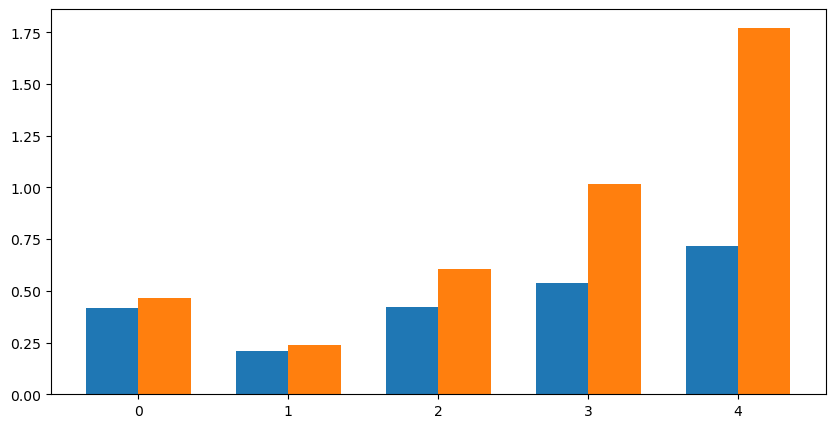

In [12]:
if __name__ == "__main__":
    tal_cells, coords = load_dataset()
    r_all, theta_all = coords[:, 0], coords[:, 1]
    stratified_main(tal_cells, theta_all, r_all)